In [111]:
import numpy as np
import pandas as pd
from typing import Tuple, List
import matplotlib.pyplot as plt
import pandas_bokeh
import copy

import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 10]

In [130]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_absolute_error as mape, mean_absolute_error as mse

rmse = lambda y_true, y_pred,: np.sqrt(mse(y_true, y_pred,))

In [131]:
# !pip install -U xgboost

## Helper functions

In [114]:
def get_champagne(years: Tuple[int, int] = (2018, 2023),
                  normal_days: dict =  {'n': 1000, 'p': 0.02},
                  weekdays: dict = {4: {'n': 1800, 'p': 0.03},
                                    5: {'n': 2000, 'p': 0.05}},
                  special_events: dict = {(29, 12): {'n': 1500, 'p': 0.1},
                                          (30, 12): {'n': 2000, 'p': 0.2},
                                          (31, 12): {'n': 2000, 'p': 0.7}}):
    """Model for sparkling wine demand"""
    df = pd.DataFrame({
        'date': pd.date_range(f'{years[0]}-01-01', f'{years[1]}-12-31')    
    })
    df['weekday'] = df.date.dt.weekday
    df['month'] = df.date.dt.month
    df['monthday'] = df.date.dt.day
    
    normal_days_amount = np.random.binomial(**normal_days, size=len(df))
    df['amount'] = normal_days_amount
    
    if weekdays:
        for wd, params in weekdays.items():
            mask = df.weekday == wd
            df.loc[mask, 'amount'] = np.random.binomial(**params, size=mask.sum())
    
    if special_events:
        for d, params in special_events.items():
            mask = (df.monthday == d[0]) & (df.month == d[1]) 
            df.loc[mask, 'amount'] = np.random.binomial(**params, size=mask.sum())
            col_name = f'special_event_{d[0]}_{d[1]}'
            df[col_name] = 0
            df.loc[mask, col_name] = 1
    
    return df

In [153]:
def train_loop(models: List[object], 
               X_train: pd.DataFrame, 
               y_train: pd.DataFrame):
    for name, model in models.items():
        if 'weighted' in name:
            model.fit(X_train, y_train, sample_weight=y_train['amount'])
        else:
            model.fit(X_train, y_train)

def test_loop(models: List[object], 
               df_results: pd.DataFrame, 
               X_test: pd.DataFrame):        
    for name, model in models.items():
        y_hat = model.predict(X_test)
        df_results[name] = y_hat 
        

def summarize(df: pd.DataFrame,
              target: str = 'amount', 
              metrics: dict = {'rmse': rmse, 'mape': mape}):
    
    models = [c for c in df.columns if c not in ['date', target]]
    results = {}
    
    for n, metric in metrics.items():
        results[n] = []
        for model in models:
            if df[model].isna().any():
                results[n].append(np.nan)
                continue
            results[n].append(metric(df[target], df[model]))
    results = pd.DataFrame(results)
    results.index = models
    return results   

In [154]:
# def to_cat(X: pd.DataFrame):
#     return X.astype('category')

def special_day_as_cat(X: pd.DataFrame):
    special_cols = X.filter(regex='special').columns.tolist()
    X[special_cols] = X[special_cols].astype('category')
    return X

## Common config

In [155]:
START_YEAR = 2018
END_YEAR = 2023

SPLIT_DATE = '2022-12-31'

TARGET = ['amount']
MODELS = {
    'lightgbm_rmse': LGBMRegressor(objective='rmse'),
    'lightgbm_rsme_weighted': LGBMRegressor(objective='rmse'),
    'lightgbm_rmse_goss': LGBMRegressor(objective='rmse', boosting_type='goss'),
    'lightgbm_rmse_lt': LGBMRegressor(objective='rmse', linear_trees=True),
    'xgboost_rmse': XGBRegressor(objective='reg:squarederror'),
    'catboost_rmse': CatBoostRegressor(objective='RMSE', verbose=0),
    
    'lightgbm_tweedie': LGBMRegressor(objective='tweedie'),
    'xgboost_tweedie': XGBRegressor(objective='reg:tweedie'),
    'catboost_tweedie': CatBoostRegressor(objective='Tweedie:variance_power=1.5', verbose=0),
    
    'lightgbm_mae': LGBMRegressor(objective='mae'),
    'xgboost_mae': XGBRegressor(objective='reg:absoluteerror'),
    'catboost_mae': CatBoostRegressor(objective='MAE', verbose=0),
    
    'lightgbm_poisson': LGBMRegressor(objective='poisson'),
    'xgboost_poisson': XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.),
    'catboost_poisson': CatBoostRegressor(objective='Poisson', verbose=0),
    
    'sklearn_rf_rmse': RandomForestRegressor(criterion='squared_error'),
    'sklearn_linear_svr': LinearSVR(),
    'sklearn_svr': SVR(),
    
    'sklearn_linear': LinearRegression()    
}

## Data

In [156]:
data = get_champagne(years=(START_YEAR, END_YEAR),
                    special_events={(31, 12): {'n': 2000, 'p': 0.7}})

train_data = data.query('date <= @SPLIT_DATE')
test_data = data.query('date > @SPLIT_DATE')

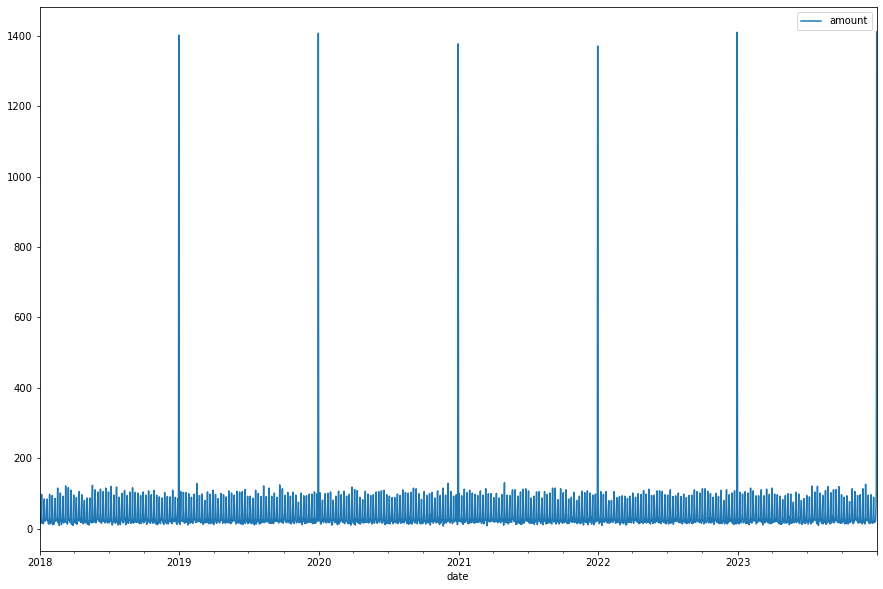

In [157]:
data.plot(x='date', y='amount')

In [158]:
train_data.query("(monthday == 31) & (month == 12)")

,date,weekday,month,monthday,amount,special_event_31_12
364,2018-12-31,0,12,31,1402,1
729,2019-12-31,1,12,31,1407,1
1095,2020-12-31,3,12,31,1377,1
1460,2021-12-31,4,12,31,1371,1
1825,2022-12-31,5,12,31,1410,1


## Without special event flag

In [159]:
FEATURES_1 = ['monthday', 
              'month',
              'weekday']


X_train_1, y_train_1 = train_data[FEATURES_1], train_data[TARGET]
X_test_1, y_test_1, df_results_1 = test_data[FEATURES_1], test_data[TARGET], test_data[TARGET + ['date']]

models_1 = copy.deepcopy(MODELS)
train_loop(models=models_1, X_train=X_train_1, y_train=y_train_1)
test_loop(models=models_1, df_results=df_results_1, X_test=X_test_1)

/tmp/ipykernel_10242/1360847562.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_10242/1360847562.py:15: SettingWithC

In [171]:
summary_1 = summarize(df_results_1)
summary_1.columns = pd.MultiIndex.from_arrays([summary_1.columns.tolist(), ['no_flag'] * len(summary_1.columns)])
peak_1 = df_results_1 \
    .set_index('date') \
    .query('date == "2023-12-31"').T
peak_1.columns = pd.MultiIndex.from_arrays([peak_1.columns.tolist(), ['no_flag']])
peak_1

,2023-12-31
,no_flag
amount,1411.000000
lightgbm_rmse,839.966489
lightgbm_rsme_weighted,1394.463996
lightgbm_rmse_goss,789.118040
lightgbm_rmse_lt,1250.230722
xgboost_rmse,1404.436523
catboost_rmse,891.604771
lightgbm_tweedie,227.139263
xgboost_tweedie,482.631561


## With special day flag

In [165]:
FEATURES_2 = ['monthday', 
             'month',
             'weekday',
             'special_event_31_12']

X_train_2, y_train_2 = train_data[FEATURES_2], train_data[TARGET]
X_test_2, y_test_2, df_results_2 = test_data[FEATURES_2], test_data[TARGET], test_data[TARGET + ['date']]

models_2 = copy.deepcopy(MODELS) 
models_2.update({
    'lightgbm_rmse_special_as_cat': make_pipeline(FunctionTransformer(special_day_as_cat),
                                                  LGBMRegressor(objective='rmse')),
    'catboost_rmse_special_as_cat': make_pipeline(FunctionTransformer(special_day_as_cat),
                                                CatBoostRegressor(objective='RMSE', verbose=0, 
                                                                  cat_features=['special_event_31_12']))
})
train_loop(models=models_2, X_train=X_train_2, y_train=y_train_2)
test_loop(models=models_2, df_results=df_results_2, X_test=X_test_2)

/tmp/ipykernel_10242/1360847562.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/krzysztof/.local/lib/python3.8/site-packages/

In [176]:
summary_2 = summarize(df_results_2)
summary_2.columns = pd.MultiIndex.from_arrays([summary_2.columns.tolist(), ['special_day_flag'] * len(summary_2.columns)])
peak_2 = df_results_2 \
    .set_index('date') \
    .query('date == "2023-12-31"').T 
peak_2.columns = pd.MultiIndex.from_arrays([peak_2.columns.tolist(), ['special_day_flag']])
peak_2

,2023-12-31
,special_day_flag
amount,1411.000000
lightgbm_rmse,839.966489
lightgbm_rsme_weighted,1394.463996
lightgbm_rmse_goss,789.118040
lightgbm_rmse_lt,1250.230722
xgboost_rmse,1410.234131
catboost_rmse,1003.844943
lightgbm_tweedie,227.139263
xgboost_tweedie,687.888672


## Summary 

In [177]:
summary_1

,rmse,mape
,no_flag,no_flag
lightgbm_rmse,2.946361,8.681043
lightgbm_rsme_weighted,2.349170,5.518600
lightgbm_rmse_goss,3.170639,10.052951
lightgbm_rmse_lt,2.645104,6.996576
xgboost_rmse,2.369348,5.613811
catboost_rmse,2.524173,6.371452
lightgbm_tweedie,2.864014,8.202575
xgboost_tweedie,2.862335,8.192960
catboost_tweedie,2.968794,8.813735


In [180]:
summary = \
    pd.concat([
        summary_1, #.add_suffix('no_flag'),
        summary_2 # .add_suffix('_special_day_flag')
    ], axis=1)

peaks = \
    pd.concat([
        peak_1, #.add_suffix('no_flag'),
        peak_2 # .add_suffix('_special_day_flag')
    ], axis=1)

## Peak

In [181]:
peaks

2023-12-31                 
                                  no_flag special_day_flag
amount                        1411.000000      1411.000000
lightgbm_rmse                  839.966489       839.966489
lightgbm_rsme_weighted        1394.463996      1394.463996
lightgbm_rmse_goss             789.118040       789.118040
lightgbm_rmse_lt              1250.230722      1250.230722
xgboost_rmse                  1404.436523      1410.234131
catboost_rmse                  891.604771      1003.844943
lightgbm_tweedie               227.139263       227.139263
xgboost_tweedie                482.631561       687.888672
catboost_tweedie                13.601865        38.587596
lightgbm_mae                    22.275039        22.275039
xgboost_mae                     18.563644        18.563644
catboost_mae                   604.138298       139.175592
lightgbm_poisson               123.302282       123.302282
xgboost_poisson                       NaN              NaN
catboost_poisson                 9.088802        66.769510
sklearn_rf_rmse               1152.360000      1399.290000
sklearn_linear_svr              32.849962        37.940265
sklearn_svr                     25.517923        25.465694
sklearn_linear                  79.665162      1416.902111
lightgbm_rmse_special_as_cat          NaN       839.966489
catboost_rmse_special_as_cat          NaN      1031.255341

## MAPE and RMSE

In [179]:
summary

,rmse,mape,rmse,mape
,no_flag,no_flag,special_day_flag,special_day_flag
lightgbm_rmse,2.946361,8.681043,2.946361,8.681043
lightgbm_rsme_weighted,2.349170,5.518600,2.349170,5.518600
lightgbm_rmse_goss,3.170639,10.052951,3.170639,10.052951
lightgbm_rmse_lt,2.645104,6.996576,2.645104,6.996576
xgboost_rmse,2.369348,5.613811,2.362406,5.580963
catboost_rmse,2.524173,6.371452,2.455628,6.030108
lightgbm_tweedie,2.864014,8.202575,2.864014,8.202575
xgboost_tweedie,2.862335,8.192960,2.775344,7.702537
catboost_tweedie,2.968794,8.813735,2.947165,8.685779
